# CS435 Term Project

## Analyze Crime Rates to Help Mitigate Crimes in Chicago

Team Members: Jimit Bhalavat, Logan Cuccia, Kyle Cummings, Mike Peyton

### Description

Chicago was once a pillar of prosperity and trade where companies housed their headquarters, where business partners formed coalitions, and where impactful business decisions were made. Today, it is still a major capital for trade, and some areas are very prosperous. Other sectors are rampant with crime, murder, theft, break-ins, and kidnappings. The crimes within some Chicago districts are so high that officers often don’t know whether they will return home that day to their families. Although there are countless factors contributing to the growing crime rate and law enforcement procedures, crimes are overwhelmingly complex and have to do with politics, state, and local government actions. The question arises how has crime changed over the years? Is it possible to predict where or when a crime will be committed? Which areas of the city have evolved over this time span?

The goal of this project is to tackle how we can use data from these crimes to potentially stop them from becoming so frequent. It will also provide data summarizations such as the location and frequency of the crimes, and the nature of the crimes which can ultimately help mitigate crimes and help law enforcement agencies pinpoint where these crimes are more likely to occur, and which districts should have a higher abundance of police officers. This information can not only save the lives of citizens but also police officers who risk their lives every day to better their communities. It also ensures that these criminals have a higher likelihood of being caught since so many crimes in these districts go unsolved. The dataset contains attributes such as date, coordinates of the incident, district, the nature of the crime, etc. We will attempt to use these attributes to generate summarizations that will assist in the fight against crime as well as assist in the city’s economic future. 

### Goal of the Project

In order to solve this problem and help aid law enforcement agencies in Chicago, we will aim to analyze this dataset and run a variety of different processing techniques and models in order to interpret results and answer the questions mentioned above. This dataset is large and contains various attributes, so it is complex to analyze through normal methods. In order to process this data effectively and efficiently, we will use MapReduce to process the data and provide numerical summarizations such as the accuracy rates of prediction through Neural Networks, Random Forests, and K Means clustering. Other numerical summarizations will include the proportions of arrests made by the crimes committed, whether the trends in crimes have increased over the years, and if yes, what crimes are more likely to be committed. 


In this project, we aim to analyze the relationship between different types of crimes and the location they happened. In our research, we also aim to analyze the statistics of a few specific crimes: theft, homicide, and sexual harassment, and whether these crimes have declined or increased over the years. We aim to use a few of the packages available in Python3 such as Pandas (Dataframe), Numpy (Math), Seaborn and Matplotlib (Data Visualization), and Sklearn (Algorithms). The framework we plan to use is Hadoop or Spark. 


### Data Description

The dataset comes from Kaggle and reflects the reported incidents of crime in the City of Chicago from 2001 to 2017. The set excludes murders where data exists for each victim. This dataset is withdrawn from the Chicago Police Department’s Citizen Law Enforcement Analysis and Reporting System. The entire dataset spans around 2GB. In order to span the 16 years of data, the entire dataset has been broken down into four different CSV files. The entries of the files have attributes such as a unique identifier, block where the incident occurred, description of the location where the incident occurred, whether the incident was domestic-related, police district where the incident occurred, latitude, and longitude of the incident, to name a few. To protect the privacy of crime victims, the exact addresses of the crimes are not shared, but the location data included will allow us to pinpoint the general location of the crime. We can use the description attributes to categorize what type of crime was committed, and also filter based on other attributes such as whether an arrest was made, or whether the case was domestic.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql.functions import format_number, when, col, array, udf, lit
import pandas as pd
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, IndexToString
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import *
import pyspark.sql.functions as F
from sklearn.cluster import KMeans
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
from __future__ import division
import datetime
import collections

### Data Processing

In [2]:
crimes_temp = pd.read_csv("../New_Data.csv")
crimes_temp.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,Longitude
0,1000,G397434,08/09/2001 07:30:00 PM,079XX S CAMPBELL AVE,0110,HOMICIDE,FIRST DEGREE MURDER,True,False,835,8.0,18.0,70.0,2001,41.749136,-87.685268
1,10000000,HY189952,03/18/2015 08:47:00 PM,042XX N MARINE DR,1330,CRIMINAL TRESPASS,TO LAND,False,False,1915,19.0,46.0,3.0,2015,41.958736,-87.646526
2,10000001,HY189865,03/10/2015 05:35:00 PM,032XX W 55TH ST,1130,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,False,False,822,8.0,14.0,63.0,2015,41.793488,-87.705332
3,10000002,HY189810,03/04/2015 12:00:00 PM,034XX W 71ST PL,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,False,False,831,8.0,18.0,66.0,2015,41.763380,-87.708888
4,10000003,HY189793,03/18/2015 06:44:00 PM,017XX N TRIPP AVE,1330,CRIMINAL TRESPASS,TO LAND,True,False,2534,25.0,30.0,20.0,2015,41.912312,-87.732517


### Map Reduce

In [3]:
crimes = pd.read_csv('MR_Results/Ward_Arrest.csv')
df = crimes.sort_values(by=['%True'], ascending=False).head(15)
df.head()

,Ward,Arrest = True,Arrest = False,%True,%False
20,28.0,133288.0,176862.0,42.98,57.02
16,24.0,103878.0,161949.0,39.08,60.92
30,37.0,65086.0,117879.0,35.57,64.43
19,27.0,85541.0,164752.0,34.18,65.82
22,3.0,69952.0,135597.0,34.03,65.97


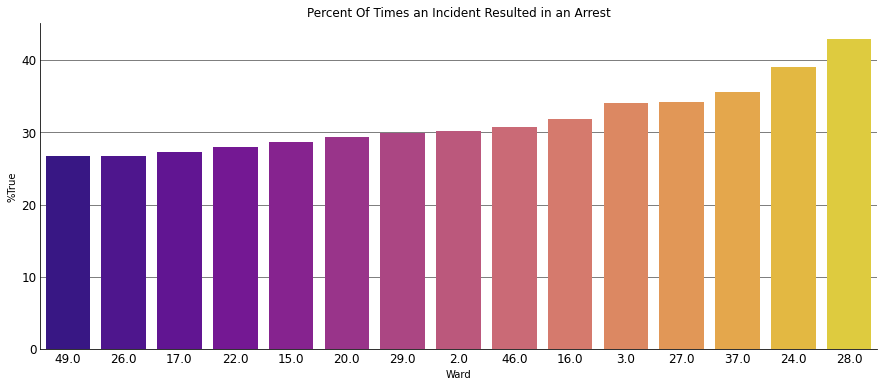

In [4]:
fig,ax = plt.subplots(figsize=(15,6))
sns.barplot(x='Ward',y='%True',data=df,ci=95,ax=ax,
    order = df.sort_values("%True").Ward, palette = 'plasma')
ax.set_title('Percent Of Times an Incident Resulted in an Arrest')
ax.tick_params(labelsize=12,length=0)
ax.yaxis.grid(linewidth=0.5,color='black')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

From the above figure, we can see that ward 28 had the highest percentage of arrests followed by ward 24.

In [5]:
war = pd.read_csv('MR_Results/Ward_PrimaryType.csv')
df = war.sort_values(by=['Ward'])
df = df.groupby(by = ['Ward']).sum()
df = df.sort_values(by=['Count'], ascending=False).head(15)
df.reset_index(level=0, inplace=True)

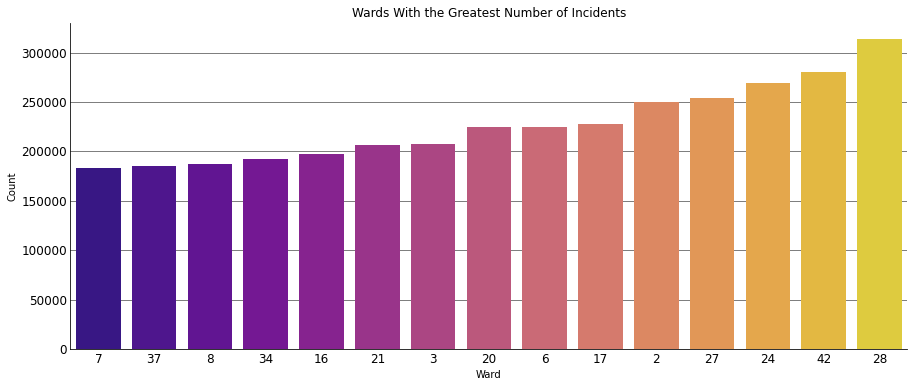

In [6]:
fig,ax = plt.subplots(figsize=(15,6))
sns.barplot(x='Ward',y='Count',data=df,ci=95,ax=ax,
    order = df.sort_values("Count").Ward, palette = 'plasma')
ax.set_title('Wards With the Greatest Number of Incidents')
ax.tick_params(labelsize=12,length=0)
ax.yaxis.grid(linewidth=0.5,color='black')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Since, ward 28, 42, and 24 had the highest number of incidents, lets expand those wards and see what crimes were committed the most in those wards.

In [7]:
w24 = war.loc[war['Ward'] == 24]
w24 = w24.sort_values(by=['Count'], ascending=False).head(7)
w42 = war.loc[war['Ward'] == 42]
w42 = w42.sort_values(by=['Count'], ascending=False).head(7)
w28 = war.loc[war['Ward'] == 28]
w28 = w28.sort_values(by=['Count'], ascending=False).head(7)


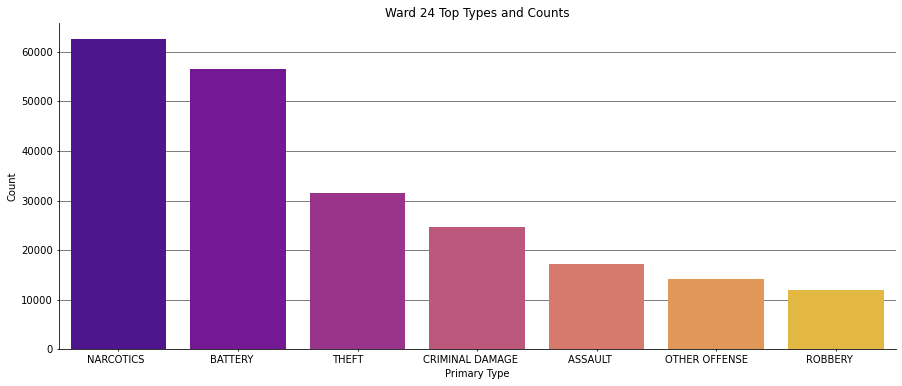

In [8]:
fig,ax = plt.subplots(figsize=(15,6))
sns.barplot(x='Primary Type',y='Count',data=w24,ci=95,ax=ax, palette = 'plasma')
ax.set_title('Ward 24 Top Types and Counts')
ax.tick_params(labelsize=10,length=2)
ax.yaxis.grid(linewidth=0.5,color='black')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

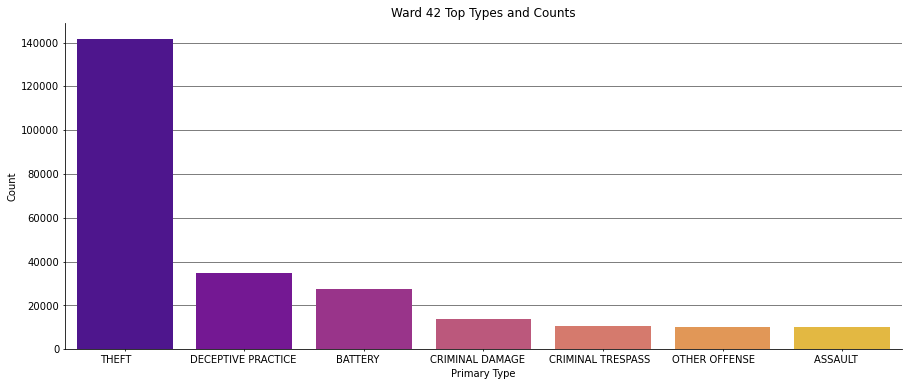

In [9]:
fig,ax = plt.subplots(figsize=(15,6))
sns.barplot(x='Primary Type',y='Count',data=w42,ci=95,ax=ax, palette = 'plasma')
ax.set_title('Ward 42 Top Types and Counts')
ax.tick_params(labelsize=10,length=2)
ax.yaxis.grid(linewidth=0.5,color='black')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

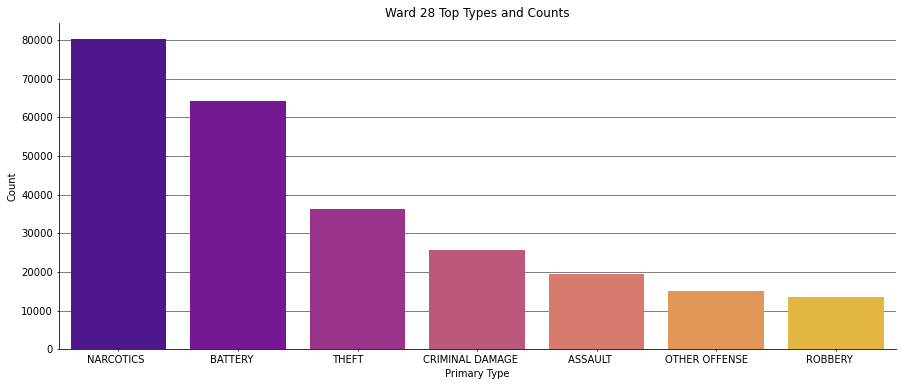

In [10]:
fig,ax = plt.subplots(figsize=(15,6))
sns.barplot(x='Primary Type',y='Count',data=w28,ci=95,ax=ax, palette = 'plasma')
ax.set_title('Ward 28 Top Types and Counts')
ax.tick_params(labelsize=10,length=2)
ax.yaxis.grid(linewidth=0.5,color='black')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Since Narcotics and Theft are the highest types of crimes committeed based on Wards, let's see how has these crimes evolved over the years in Chicago.

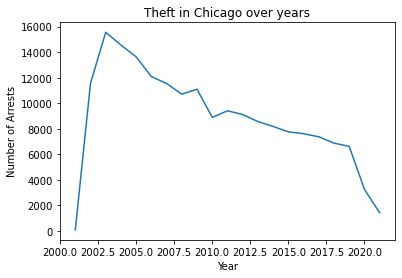

In [11]:
plt.plot(figsize=(10,10))
plt.ylabel('Number of Arrests')
plt.xlabel('Year')
plt.title('Theft in Chicago over years')
plt.plot(crimes_temp.loc[crimes_temp['Primary Type'].str.contains('THEFT')].groupby(by = ['Year']).sum()['Arrest'])
plt.show()

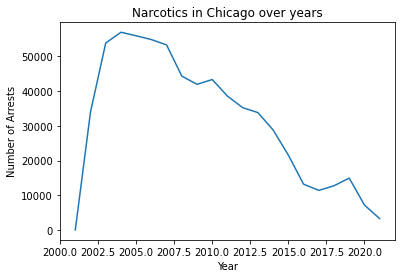

In [12]:
plt.plot(figsize=(10,10))
plt.ylabel('Number of Arrests')
plt.xlabel('Year')
plt.title('Narcotics in Chicago over years')
plt.plot(crimes_temp.loc[crimes_temp['Primary Type'].str.contains('NARCOTICS')].groupby(by = ['Year']).sum()['Arrest'])
plt.show()

### K-Nearest Neighbors (KNN)

In [13]:
crimes = crimes_temp
crimes['PrimTypeInt'] = crimes['Primary Type'].rank(method='dense', ascending=False).astype(int)
types = []
typeFlag = False
for item in crimes.columns:
    typeFlag = False
    for t in types:
        if(t == item):
            typeFlag = True
    if not typeFlag:
      types.append(item)       
print(f'Types being used: {types}')

Types being used: ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'Year', 'Latitude', 'Longitude', 'PrimTypeInt']


In [14]:
def plot_correlation(data):
    # plot correlation's matrix to explore dependency between features 
    fig = plt.figure(figsize= (7, 7))
    cor = data.corr()
    sns.heatmap(cor, annot=True, fmt=".2f")
    plt.show()

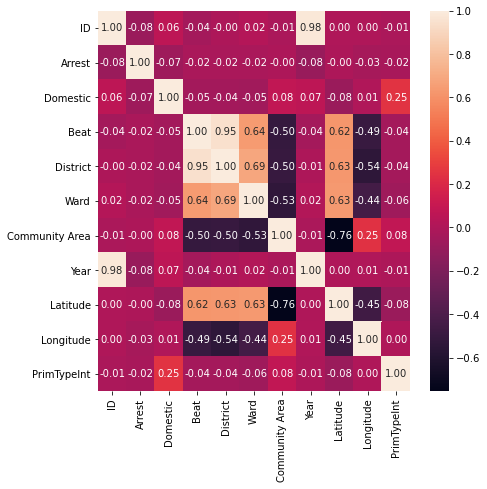

In [15]:
plot_correlation(crimes)

In [16]:
def split_70_30(df) :
    # Using Latitude and Longitude as features
    X = df[['Latitude', 'Longitude']].values
    y = df['Primary Type'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    return X_train, X_test, y_train, y_test

def run_nearest_neighbor(df, k) :
    X_train, X_test, y_train, y_test = split_70_30(df)
    print(f'Creating KNeigborsClassifier: k = {k}')
    print('Fitting...')
    knn1 = KNeighborsClassifier(k)
    knn1.fit(X_train, y_train)
    print('Finished fitting model..')
    print('Predicting...')
    y_pred1 = knn1.predict(X_test)
    print('Finished predicting..')
    print(f'The np.mean(y_pred1==y_test) accuracy: {np.mean(y_pred1==y_test):1.3f}\n')
    print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred1):1.3f}\n')
    print(f"F1 score: {metrics.f1_score(y_test, y_pred1, average = 'weighted'):1.3f}\n")
    print('First 13 Correct Predictions:')
    correctStr = []
    correct = []
    for i in range(len(X_test)):
        if y_pred1[i]==y_test[i]:
            correct.append(y_pred1[i])
            correctStr.append(f'Latitude and Longitude: {X_test[i]} Crime Predicted: {y_pred1[i]}')
    for j in range(13):
        print(correctStr[j])
    counter = collections.Counter(correct)
    print('\nMost common occurances of correctly predicted crimes:')
    print(counter.most_common())


In [17]:
run_nearest_neighbor(crimes, 15)

Creating KNeigborsClassifier: k = 15
Fitting...
Finished fitting model..
Predicting...
Finished predicting..
The np.mean(y_pred1==y_test) accuracy: 0.285

Accuracy: 0.285

F1 score: 0.254

First 13 Correct Predictions:
Latitude and Longitude: [ 41.80043565 -87.68543364] Crime Predicted: CRIMINAL DAMAGE
Latitude and Longitude: [ 41.75302178 -87.66471692] Crime Predicted: BATTERY
Latitude and Longitude: [ 41.89615524 -87.72243868] Crime Predicted: NARCOTICS
Latitude and Longitude: [ 41.76610239 -87.57353917] Crime Predicted: THEFT
Latitude and Longitude: [ 41.90448852 -87.64056534] Crime Predicted: THEFT
Latitude and Longitude: [ 41.89441976 -87.7089646 ] Crime Predicted: CRIMINAL DAMAGE
Latitude and Longitude: [ 41.97753379 -87.66836819] Crime Predicted: THEFT
Latitude and Longitude: [ 41.76352201 -87.69422464] Crime Predicted: CRIMINAL DAMAGE
Latitude and Longitude: [ 41.79220682 -87.61591557] Crime Predicted: BATTERY
Latitude and Longitude: [ 41.96331282 -87.72054743] Crime Predicted:

### K-Means Clustering

In [18]:
crimes = crimes_temp
crimes['Date'] = pd.to_datetime(crimes.Date) 
crimes['date'] = [d.date() for d in crimes['Date']]
crimes['time'] = [d.time() for d in crimes['Date']]

crimes['time'] = crimes['time'].astype(str)
empty_list = []
for timestr in crimes['time'].tolist():
    ftr = [3600,60,1]
    var = sum([a*b for a,b in zip(ftr, map(int,timestr.split(':')))])
    empty_list.append(var)

crimes['seconds'] = empty_list

In [19]:
sub_data = crimes[['Ward', 'IUCR', 'District']]
sub_data = sub_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
sub_data['IUCR'] = sub_data.IUCR.str.extract('(\d+)', expand=True).astype(int)
sub_data.head()

,Ward,IUCR,District
0,18.0,110,8.0
1,46.0,1330,19.0
2,14.0,1130,8.0
3,18.0,1153,8.0
4,30.0,1330,25.0


In [20]:
N = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in N]
print(kmeans)
score = [kmeans[i].fit(sub_data).score(sub_data) for i in range(len(kmeans))]
print(score)

[KMeans(n_clusters=1), KMeans(n_clusters=2), KMeans(n_clusters=3), KMeans(n_clusters=4), KMeans(n_clusters=5), KMeans(n_clusters=6), KMeans(n_clusters=7), KMeans(), KMeans(n_clusters=9)]
[-4509778866870.785, -1702540848993.22, -782434670463.0284, -434780112335.8798, -259179286157.88562, -115810369670.71693, -69838675758.68195, -50453465813.720695, -38544032606.66625]


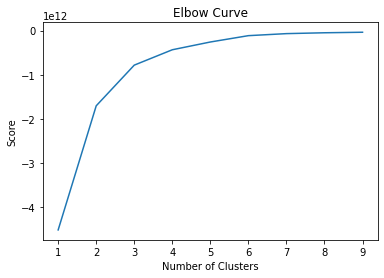

In [21]:
pl.plot(N,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [22]:
sub_data['IUCR'] = (sub_data['IUCR'] - sub_data['IUCR'].min())/(sub_data['IUCR'].max()-sub_data['IUCR'].min())
sub_data['Ward'] = (sub_data['Ward'] - sub_data['Ward'].min())/(sub_data['Ward'].max()-sub_data['Ward'].min())
sub_data['District'] = (sub_data['District'] - sub_data['District'].min())/(sub_data['District'].max()-sub_data['District'].min())

In [23]:
km = KMeans(n_clusters=4)
km.fit(sub_data)
y = km.predict(sub_data)
labels = km.labels_
sub_data['Clusters'] = y
sub_data.head()

,Ward,IUCR,District,Clusters
0,0.346939,0.015487,0.233333,0
1,0.918367,0.254656,0.600000,1
2,0.265306,0.215448,0.233333,0
3,0.346939,0.219957,0.233333,0
4,0.591837,0.254656,0.800000,1


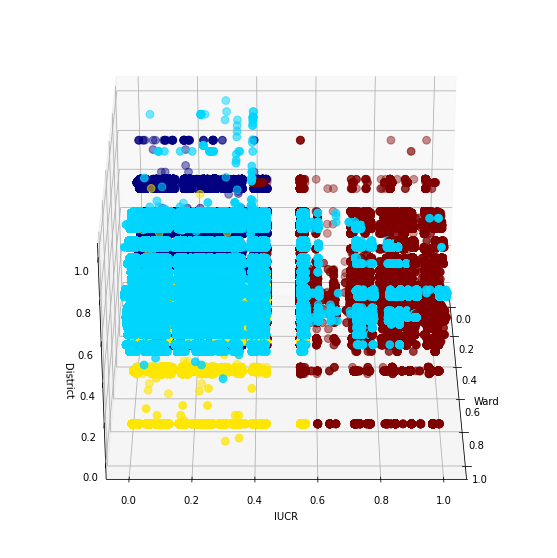

In [24]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(sub_data['Ward'])
y = np.array(sub_data['IUCR'])
z = np.array(sub_data['District'])

ax.set_xlabel('Ward')
ax.set_ylabel('IUCR')
ax.set_zlabel('District')

ax.scatter(x,y,z, marker="o", c = sub_data["Clusters"], s=60, cmap="jet")
ax.view_init(azim=0)
plt.show()

In [25]:
crimes['Normalized_time'] = (crimes['seconds'] - crimes['seconds'].min())/(crimes['seconds'].max()-crimes['seconds'].min())

sub_data1 = crimes[['IUCR', 'Normalized_time', 'District']]
sub_data1['IUCR'] = sub_data1.IUCR.str.extract('(\d+)', expand=True).astype(int)
sub_data1['IUCR'] = (sub_data1['IUCR'] - sub_data1['IUCR'].min())/(sub_data1['IUCR'].max()-sub_data1['IUCR'].min())
sub_data1['District'] = (sub_data1['District'] - sub_data1['District'].min())/(sub_data1['District'].max()-sub_data1['District'].min())
sub_data1.head()

<ipython-input-25-dad932a78114>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['IUCR'] = sub_data1.IUCR.str.extract('(\d+)', expand=True).astype(int)
<ipython-input-25-dad932a78114>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['IUCR'] = (sub_data1['IUCR'] - sub_data1['IUCR'].min())/(sub_data1['IUCR'].max()-sub_data1['IUCR'].min())
<ipython-input-25-dad932a78114>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,IUCR,Normalized_time,District
0,0.015487,0.812509,0.233333
1,0.254656,0.865982,0.600000
2,0.215448,0.732647,0.233333
3,0.219957,0.500006,0.233333
4,0.254656,0.780565,0.800000


In [26]:
N = range(1, 10)
kmeans = [KMeans(n_clusters=i) for i in N]
print(kmeans)
score = [kmeans[i].fit(sub_data1).score(sub_data1) for i in range(len(kmeans))]
score

[KMeans(n_clusters=1), KMeans(n_clusters=2), KMeans(n_clusters=3), KMeans(n_clusters=4), KMeans(n_clusters=5), KMeans(n_clusters=6), KMeans(n_clusters=7), KMeans(), KMeans(n_clusters=9)]


[-1067495.189960846,
 -689176.0448591987,
 -499264.0500393977,
 -419539.6861000505,
 -349740.71620428545,
 -293929.5757787677,
 -261502.2731494872,
 -241500.18235689827,
 -224866.82462334805]

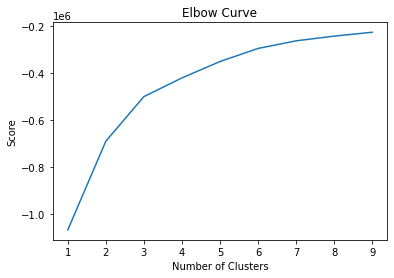

In [27]:
pl.plot(N,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [28]:
km = KMeans(n_clusters=4)
km.fit(sub_data1)
y = km.predict(sub_data1)
labels = km.labels_
sub_data1['Clusters'] = y
sub_data1.head()

<ipython-input-28-d3039a00eb58>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


,IUCR,Normalized_time,District,Clusters
0,0.015487,0.812509,0.233333,0
1,0.254656,0.865982,0.600000,3
2,0.215448,0.732647,0.233333,0
3,0.219957,0.500006,0.233333,2
4,0.254656,0.780565,0.800000,3


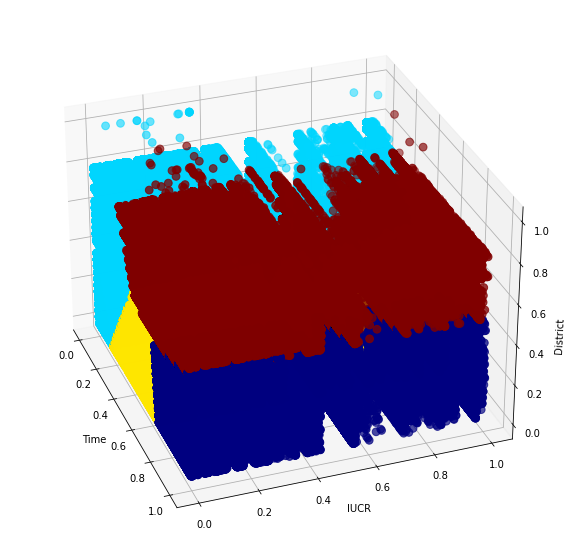

In [29]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')
x = np.array(sub_data1['Normalized_time'])
y = np.array(sub_data1['IUCR'])
z = np.array(sub_data1['District'])

ax.set_xlabel('Time')
ax.set_ylabel('IUCR')
ax.set_zlabel('District')

ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="jet")
ax.view_init(azim=-20)
plt.show()

### Random Forests

In [30]:

spark = SparkSession.builder.appName("Analyze Chicago Crime").config("spark.some.config.option", "value").config("spark.driver.memory", "8g").config("spark.driver.cores", "3").getOrCreate()

In [31]:

crimes_schema = StructType([StructField("ID", StringType(), True),
                            StructField("Case Number", StringType(), True),
                            StructField("Date", StringType(), True ),
                            StructField("Block", StringType(), True),
                            StructField("IUCR", StringType(), True),
                            StructField("Primary Type", StringType(), True  ),
                            StructField("Description", StringType(), True ),
                            StructField("Location Description", StringType(), True ),
                            StructField("Arrest", BooleanType(), True),
                            StructField("Domestic", BooleanType(), True),
                            StructField("Beat", StringType(), True),
                            StructField("District", StringType(), True),
                            StructField("Ward", StringType(), True),
                            StructField("Community Area", StringType(), True),
                            StructField("FBI Code", StringType(), True ),
                            StructField("X Coordinate", DoubleType(), True),
                            StructField("Y Coordinate", DoubleType(), True ),
                            StructField("Year", IntegerType(), True),
                            StructField("Updated On", DateType(), True ),
                            StructField("Latitude", DoubleType(), True),
                            StructField("Longitude", DoubleType(), True),
                            StructField("Location", StringType(), True )
                            ])

In [32]:
dataset = spark.read.option("header", "True").option("inferSchema", "true").csv("../Crimes_-_2001_to_present.csv")

In [33]:
dataset.limit(5).toPandas().head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,-87.670000,"(41.815117282, -87.669999562)",29.0,14924.0,59.0,706.0,3.0,37.0,23.0,108.0
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,-87.765400,"(41.895080471, -87.765400451)",4.0,4299.0,26.0,562.0,45.0,5.0,25.0,67.0
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,...,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,-87.716650,"(41.937405765, -87.716649687)",15.0,21538.0,22.0,216.0,12.0,39.0,7.0,168.0
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,-87.755121,"(41.881903443, -87.755121152)",11.0,22216.0,26.0,696.0,23.0,32.0,25.0,81.0


In [34]:
dataset = dataset.filter((dataset['Primary Type']!='STALKING')&
                             (dataset['Primary Type']!='OBSCENITY')&
                             (dataset['Primary Type']!='NON-CRIMINAL (SUBJECT SPECIFIED)')&
                             (dataset['Primary Type']!='GAMBLING')&
                             (dataset['Primary Type']!='NON - CRIMINAL')&
                             (dataset['Primary Type']!='LIQUOR LAW VIOLATION')&
                             (dataset['Primary Type']!='PUBLIC INDECENCY')&
                             (dataset['Primary Type']!='HUMAN TRAFFICKING')&
                             (dataset['Primary Type']!='INTIMIDATION')&
                             (dataset['Primary Type']!='CONCEALED CARRY LICENSE VIOLATION')&
                             (dataset['Primary Type']!='NON-CRIMINAL')&
                             (dataset['Primary Type']!='OTHER NARCOTIC VIOLATION'))

In [35]:

dataset = dataset.withColumn("Day", F.split(dataset.Date, " ")[0])
dataset = dataset.withColumn("Day", F.to_date(dataset.Day, "MM/dd/yyyy"))
dataset = dataset.withColumn("Month", F.month(dataset.Day))
dataset = dataset.withColumn("WeekDay", F.dayofweek(dataset.Day))
dataset = dataset.withColumn("Hour", F.split(F.split(dataset.Date," ")[1], ":")[0].cast("int"))
dataset = dataset.na.drop()
dataset.limit(5).toPandas().head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Day,Month,WeekDay,Hour
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,59,706,3,37,23,108,2015-09-05,9,7,1
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,...,26,562,45,5,25,67,2015-09-04,9,6,11
2,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,...,22,216,12,39,7,168,2015-09-05,9,7,12
3,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,26,696,23,32,25,81,2015-09-05,9,7,1
4,10224742,HY411435,09/05/2015 10:55:00 AM,082XX S LOOMIS BLVD,0610,BURGLARY,FORCIBLE ENTRY,RESIDENCE,False,False,...,70,575,13,59,20,237,2015-09-05,9,7,10


In [36]:

dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'CRIM SEXUAL ASSAULT') | \
                                    (dataset["Primary Type"] == 'PROSTITUTION') ,'SEX OFFENSE').otherwise(dataset['Primary Type']))
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'WEAPONS VIOLATION') | \
                                    (dataset["Primary Type"] == 'INTERFERENCE WITH PUBLIC OFFICER') ,'PUBLIC PEACE VIOLATION').otherwise(dataset['Primary Type']))
dataset = dataset.withColumn("Primary Type", \
                               when((dataset["Primary Type"] == 'ARSON') ,'CRIMINAL TRESPASS').otherwise(dataset['Primary Type']))

In [37]:
dataset = dataset.na.drop()
dataset = dataset.drop('ID')
dataset = dataset.drop('Case Number')
dataset = dataset.drop('Block')
dataset = dataset.drop('IUCR')
dataset = dataset.drop('FBI Code')
dataset = dataset.drop('Updated On')
dataset = dataset.drop('X Coordinate')
dataset = dataset.drop('Y Coordinate')
dataset = dataset.drop('Description')
dataset = dataset.drop('Location')
dataset = dataset.drop('Date')
dataset.limit(5).toPandas().head(5)

,Primary Type,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,Year,Latitude,...,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats,Day,Month,WeekDay,Hour
0,BATTERY,RESIDENCE,False,True,924,9,12,61,2015,41.815117,...,59,706,3,37,23,108,2015-09-05,9,7,1
1,THEFT,CTA BUS,False,False,1511,15,29,25,2015,41.895080,...,26,562,45,5,25,67,2015-09-04,9,6,11
2,NARCOTICS,SIDEWALK,True,False,1412,14,35,21,2015,41.937406,...,22,216,12,39,7,168,2015-09-05,9,7,12
3,ASSAULT,APARTMENT,False,True,1522,15,28,25,2015,41.881903,...,26,696,23,32,25,81,2015-09-05,9,7,1
4,BURGLARY,RESIDENCE,False,False,614,6,21,71,2015,41.744379,...,70,575,13,59,20,237,2015-09-05,9,7,10


In [38]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude"], outputCol="features")
df_temp = vector_assembler.transform(dataset)
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)


labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=labelIndexer.labels)


(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)

predictions.groupBy("predictedLabel").count().show()

+--------------+------+
|predictedLabel| count|
+--------------+------+
|         THEFT|824035|
|       BATTERY|987974|
|     NARCOTICS|195485|
+--------------+------+



In [39]:
from pyspark.ml.feature import OneHotEncoder
locationIndexer = StringIndexer(inputCol="Location Description", outputCol="indexedLocation").fit(dataset).transform(dataset)
encoded_data = OneHotEncoder(inputCols=["indexedLocation"],outputCols=["encodedLocation"]).fit(locationIndexer).transform(locationIndexer)

In [40]:
vector_assembler = VectorAssembler(inputCols = ["Latitude", "Longitude", "Arrest", "Beat", "Ward", "Community Area", "WeekDay", "Hour", "encodedLocation"], outputCol="features")
df_temp = vector_assembler.transform(encoded_data)
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(df_temp)

labelIndexer = StringIndexer(inputCol="Primary Type", outputCol="indexedLabel").fit(df_temp)
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",labels=labelIndexer.labels)

(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10,impurity='gini', maxBins=32)

pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

model = pipeline.fit(trainingData)

predictions = model.transform(testData)

evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
evaluator2 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

accuracy = evaluator.evaluate(predictions)
f1 = evaluator2.evaluate(predictions)

predictions.groupBy("predictedLabel").count().show()

+-----------------+-------+
|   predictedLabel|  count|
+-----------------+-------+
|CRIMINAL TRESPASS|    537|
|            THEFT|1299369|
|          BATTERY| 389039|
|        NARCOTICS| 290116|
|         BURGLARY|  31524|
+-----------------+-------+



In [41]:
labels = labelIndexer.labels
prediction_probility= predictions.select("Primary Type","Latitude","Longitude","District", "Ward","probability")

def addCrimeIndex(li):
    dic = {}
    for i in range(len(labels)):
        dic[labels[i]]=li[i]
    return dic

probability_to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))
prediction_probility = prediction_probility.withColumn('probability', probability_to_array(prediction_probility.probability))

probability_to_dict = udf(addCrimeIndex)

prediction_probility = prediction_probility.withColumn('probability', probability_to_dict(prediction_probility.probability))

pd.set_option('display.max_colwidth', None)
prediction_probility.limit(5).toPandas().head()

,Primary Type,Latitude,Longitude,District,Ward,probability
0,ASSAULT,41.856510,-87.694361,10,28,"{HOMICIDE=0.0018147862032702026, BATTERY=0.17301727925065039, ROBBERY=0.03603906972382215, SEX OFFENSE=0.016065094897780092, OFFENSE INVOLVING CHILDREN=0.007239314935456355, CRIMINAL SEXUAL ASSAULT=7.714377723901407E-4, NARCOTICS=0.0826162739784455, CRIMINAL TRESPASS=0.039383704798572464, RITUALISM=3.184291271852595E-6, CRIMINAL DAMAGE=0.12623948515919148, DECEPTIVE PRACTICE=0.0394746236129355, OTHER OFFENSE=0.06333274277667642, PUBLIC PEACE VIOLATION=0.019966199593732633, ASSAULT=0.062226480837918687, MOTOR VEHICLE THEFT=0.047501583241666936, KIDNAPPING=9.272597620481809E-4, BURGLARY=0.07199133565277324, THEFT=0.2113901435113974}"
1,ASSAULT,41.932713,-87.649312,19,44,"{HOMICIDE=0.0010745937406533633, BATTERY=0.14233796156432374, ROBBERY=0.03167201424031682, SEX OFFENSE=0.015049161046854201, OFFENSE INVOLVING CHILDREN=0.005034012338400391, CRIMINAL SEXUAL ASSAULT=9.063232175004467E-4, NARCOTICS=0.05049215568982367, CRIMINAL TRESPASS=0.040332952210553386, RITUALISM=2.482869104913097E-6, CRIMINAL DAMAGE=0.11356010280647012, DECEPTIVE PRACTICE=0.0653843830282494, OTHER OFFENSE=0.05919359427937709, PUBLIC PEACE VIOLATION=0.013220077559588402, ASSAULT=0.04931156254019631, MOTOR VEHICLE THEFT=0.03575255505132989, KIDNAPPING=7.629091922025633E-4, BURGLARY=0.07036548897461953, THEFT=0.305547669650436}"
2,ASSAULT,41.765592,-87.621131,3,6,"{HOMICIDE=0.0018594430900963957, BATTERY=0.17439192321863883, ROBBERY=0.03578811849171567, SEX OFFENSE=0.01533144835788503, OFFENSE INVOLVING CHILDREN=0.007076497476605206, CRIMINAL SEXUAL ASSAULT=7.798290043128525E-4, NARCOTICS=0.07639422138546363, CRIMINAL TRESPASS=0.03988186522398135, RITUALISM=3.085240635892653E-6, CRIMINAL DAMAGE=0.12722955408512585, DECEPTIVE PRACTICE=0.039634036466271255, OTHER OFFENSE=0.062290437977493326, PUBLIC PEACE VIOLATION=0.019124362165268038, ASSAULT=0.06240778295963993, MOTOR VEHICLE THEFT=0.046744919923984884, KIDNAPPING=9.165094653192476E-4, BURGLARY=0.07319988207932937, THEFT=0.21694608338823346}"
3,ASSAULT,41.852346,-87.665346,12,25,"{HOMICIDE=0.0018594430900963957, BATTERY=0.17439192321863883, ROBBERY=0.03578811849171567, SEX OFFENSE=0.01533144835788503, OFFENSE INVOLVING CHILDREN=0.007076497476605206, CRIMINAL SEXUAL ASSAULT=7.798290043128525E-4, NARCOTICS=0.07639422138546363, CRIMINAL TRESPASS=0.03988186522398135, RITUALISM=3.085240635892653E-6, CRIMINAL DAMAGE=0.12722955408512585, DECEPTIVE PRACTICE=0.039634036466271255, OTHER OFFENSE=0.062290437977493326, PUBLIC PEACE VIOLATION=0.019124362165268038, ASSAULT=0.06240778295963993, MOTOR VEHICLE THEFT=0.046744919923984884, KIDNAPPING=9.165094653192476E-4, BURGLARY=0.07319988207932937, THEFT=0.21694608338823346}"
4,ASSAULT,41.785039,-87.751886,8,23,"{HOMICIDE=0.0017056441261124877, BATTERY=0.18673685146939803, ROBBERY=0.03882781316868098, SEX OFFENSE=0.013820176213124783, OFFENSE INVOLVING CHILDREN=0.007589881394922895, CRIMINAL SEXUAL ASSAULT=5.769366795822766E-4, NARCOTICS=0.0665132590586582, CRIMINAL TRESPASS=0.026139059894339938, RITUALISM=3.2863353421354485E-6, CRIMINAL DAMAGE=0.12905612259336954, DECEPTIVE PRACTICE=0.04304844593072905, OTHER OFFENSE=0.06632150286253483, PUBLIC PEACE VIOLATION=0.019068794664051095, ASSAULT=0.06798796021350337, MOTOR VEHICLE THEFT=0.05277089044324024, KIDNAPPING=9.279550818650463E-4, BURGLARY=0.05912933138699915, THEFT=0.21977608848354585}"
